In [1]:
import numpy as np
from scipy.special import *
from scipy.constants import *

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
init_printing()

In [2]:
def sphericalh1(n, z):
    return spherical_jn(n, z) + 1j * spherical_yn(n, z)

def sphericalh1p(n, z):
    return spherical_jn(n, z, 1) + 1j * spherical_yn(n, z, 1)

# electric Mie coefficent
def Mie_an(n, m, x, mu=1):
    """
    For detatails see Bohren p. 100
    
    Arguments:
        - `m = N1/N = n_p / n_m` : relative refractive index;
        - `x = n_m k0 a` : size parameter;
        - `n` : 2^n multipole order;
        - `mu = mu_p / mu_m` : relative magnetic permittivity
    """
    mx = m * x
    jnmx = spherical_jn(n, mx)
    jnx = spherical_jn(n, x)
    h1nx = sphericalh1(n, x)
    xjnx_p = jnx + x * spherical_jn(n, x, 1)
    mxjnmx_p = jnmx + mx * spherical_jn(n, mx, 1)
    xh1nx_p = h1nx + x * sphericalh1p(n, x)
    
    return (m**2 * jnmx * xjnx_p - mu * jnx * mxjnmx_p) / (m**2 * jnmx * xh1nx_p - mu * h1nx * mxjnmx_p)

# magnetic Mie coefficent
def Mie_bn(n, m, x, mu=1):
    """
    For detatails see Bohren p. 100
    
    Arguments:
        - `m = N1 / N = n_p / n_m` : relative refractive index;
        - `x = n_m k0 a` : size parameter;
        - `n` : 2^n multipole order;
        - `mu = mu1 / mu =  mu_p / mu_m` : relative magnetic permittivity
    """
    mx = m * x
    jnmx = spherical_jn(n, mx)
    jnx = spherical_jn(n, x)
    h1nx = sphericalh1(n, x)
    xjnx_p = jnx + x * spherical_jn(n, x, 1)
    mxjnmx_p = jnmx + mx * spherical_jn(n, mx, 1)
    xh1nx_p = h1nx + x * sphericalh1p(n, x)

    return (mu * jnmx * xjnx_p - jnx * mxjnmx_p) / (mu * jnmx * xh1nx_p - h1nx * mxjnmx_p)



def sigma_sc(a, k0, eps_host, eps_p, mu_host=1, mu_p=1, nmin=1, nmax=100, part="both"):
    m = np.sqrt(eps_p * mu_p / (eps_host * mu_host))
    n_m = np.sqrt(eps_host * mu_host)
    x = n_m * k0 * a
    mu = mu_p / mu_host
    
    SUM = 0
    for n in range(nmin, nmax+1):
        an = Mie_an(n, m, x, mu=mu)
        bn = Mie_bn(n, m, x, mu=mu)
        
        if part=="el":
            bn = 0
        if part=="mag":
            an = 0
        
        SUM += (2*n + 1) * (np.abs(an)**2 + np.abs(bn)**2)
    
    return 2*np.pi / (k0 * n_m)**2 * SUM



def sigma_ext(a, k0, eps_host, eps_p, mu_host=1, mu_p=1, nmin=1, nmax=100, part="both"):
    m = np.sqrt(eps_p * mu_p / (eps_host * mu_host))
    n_m = np.sqrt(eps_host * mu_host)
    x = n_m * k0 * a
    mu = mu_p / mu_host
    
    SUM = 0
    for n in range(nmin, nmax+1):
        an = Mie_an(n, m, x, mu=mu)
        bn = Mie_bn(n, m, x, mu=mu)
        
        if part=="el":
            bn = 0
        if part=="mag":
            an = 0
        
        SUM += (2*n + 1) * (np.real(an) + np.real(bn))
    
    return 2*np.pi / (k0 * n_m)**2 * SUM


def sigma_abs(a, k0, eps_host, eps_p, mu_host=1, mu_p=1, nmin=1, nmax=100):
    ext = sigma_ext(a, k0, eps_host, eps_p, mu_host=mu_host, mu_p=mu_p, nmin=nmin, nmax=nmax)
    sc = sigma_sc(a, k0, eps_host, eps_p, mu_host=mu_host, mu_p=mu_p, nmin=nmin, nmax=nmax)
    
    return ext - sc

In [3]:
wl = 1064*nano
k0 = 2*pi/wl

eps_host = 1
mu_p = 1
eps_p = 16 

aa = np.linspace(80*nano, stop=200*nano, num=1500)

Q_ext = sigma_ext(aa, k0, eps_host, eps_p) / (pi * aa**2)

Q_ext_dipole_el = sigma_ext(aa, k0, eps_host, eps_p, nmin=1, nmax=1, part="el") / (pi * aa**2)
Q_ext_dipole_mag = sigma_ext(aa, k0, eps_host, eps_p, nmin=1, nmax=1, part="mag") / (pi * aa**2)
Q_ext_quad_el = sigma_ext(aa, k0, eps_host, eps_p, nmin=2, nmax=2, part="el") / (pi * aa**2)
Q_ext_quad_mag = sigma_ext(aa, k0, eps_host, eps_p, nmin=2, nmax=2, part="mag") / (pi * aa**2)


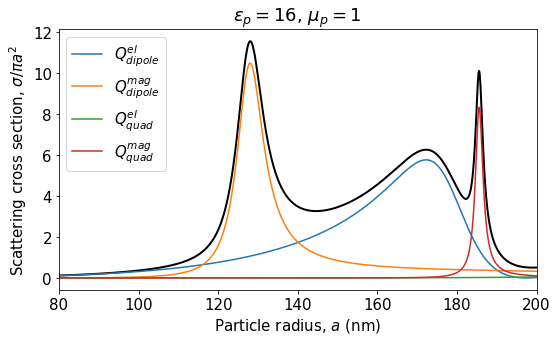

In [4]:
plt.figure(figsize=(8, 5))

plt.title("$\\varepsilon_p = $" + str(eps_p) + ", $\\mu_p = $" + str(mu_p))

plt.plot(aa/nano, Q_ext, lw=2, c="k")
plt.plot(aa/nano, Q_ext_dipole_el, label="$Q^{el}_{dipole}$")
plt.plot(aa/nano, Q_ext_dipole_mag, label="$Q^{mag}_{dipole}$")
plt.plot(aa/nano, Q_ext_quad_el, label="$Q^{el}_{quad}$")
plt.plot(aa/nano, Q_ext_quad_mag, label="$Q^{mag}_{quad}$")


plt.ylabel("Scattering cross section, $\sigma / \pi a^2$")
plt.xlabel("Particle radius, $a$ (nm)")

plt.margins(x=0)

plt.legend(loc=2)

plt.tight_layout()
plt.show()

In [5]:
wl = 1064*nano
k0 = 2*pi/wl

eps_host = 1
eps_p = 1
mu_p = 16

aa = np.linspace(80*nano, stop=200*nano, num=1500)

Q_ext = sigma_ext(aa, k0, eps_host, eps_p, mu_p=mu_p) / (pi * aa**2)

Q_ext_dipole_el = sigma_ext(aa, k0, eps_host, eps_p, mu_p=mu_p, nmin=1, nmax=1, part="el") / (pi * aa**2)
Q_ext_dipole_mag = sigma_ext(aa, k0, eps_host, eps_p, mu_p=mu_p, nmin=1, nmax=1, part="mag") / (pi * aa**2)
Q_ext_quad_el = sigma_ext(aa, k0, eps_host, eps_p, mu_p=mu_p, nmin=2, nmax=2, part="el") / (pi * aa**2)
Q_ext_quad_mag = sigma_ext(aa, k0, eps_host, eps_p, mu_p=mu_p, nmin=2, nmax=2, part="mag") / (pi * aa**2)


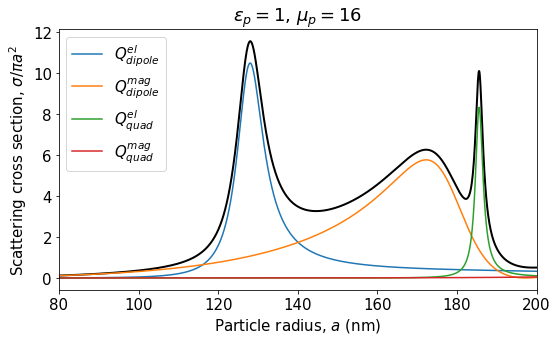

In [6]:
plt.figure(figsize=(8, 5))

plt.title("$\\varepsilon_p = $" + str(eps_p) + ", $\\mu_p = $" + str(mu_p))

plt.plot(aa/nano, Q_ext, lw=2, c="k")
plt.plot(aa/nano, Q_ext_dipole_el, label="$Q^{el}_{dipole}$")
plt.plot(aa/nano, Q_ext_dipole_mag, label="$Q^{mag}_{dipole}$")
plt.plot(aa/nano, Q_ext_quad_el, label="$Q^{el}_{quad}$")
plt.plot(aa/nano, Q_ext_quad_mag, label="$Q^{mag}_{quad}$")


plt.ylabel("Scattering cross section, $\sigma / \pi a^2$")
plt.xlabel("Particle radius, $a$ (nm)")

plt.margins(x=0)

plt.legend(loc=2)

plt.tight_layout()
plt.show()

# Chiral particle

See 
- Wang, S. B. & Chan, C. T. Lateral optical force on chiral particles near a surface. Nature Communications 5, 3307 (2014).

Mie scattering problem of the particle defind as
$$
\begin{bmatrix}
\mathbf{D} \\ \mathbf{B}
\end{bmatrix} = 
\begin{bmatrix}
\varepsilon_r \varepsilon_0 & i \kappa /c \\
- i \kappa /c & \mu_r \mu_0 
\end{bmatrix} 
\begin{bmatrix}
\mathbf{E} \\ \mathbf{H}
\end{bmatrix} 
$$
gives three scattering coefficents: $a_n$, $b_n$ and $c_n = c_n(\kappa)$. Here we focus on the later one, which is resposible for the chiral effects. We note that $c_n(\kappa = 0)= 0$.

In [10]:
def riccati_psi(n, z):
    return z * spherical_jn(n, z)

def riccati_psip(n, z):
    return spherical_jn(n, z) + z * spherical_jn(n, z, 1)

def riccati_xi(n, z):
    return z * sphericalh1(n, z)

def riccati_xip(n, z):
    return sphericalh1(n, z) + z * sphericalh1p(n, z)


# chiral Mie coefficent
def Mie_chiral_cn(n, eps_host, eps_p, mu_host, mu_p, k0a, kappa):
    """
    For detatails see 
        Wang, S. B. & Chan, C. T. 
        Lateral optical force on chiral particles near a surface. 
        Nature Communications 5, 3307 (2014).
    """
    x = k0a
    eps_r = eps_p / eps_host
    mu_r = mu_p / mu_host
    mL = np.sqrt(eps_r * mu_r + 0.0j) + kappa
    mR = np.sqrt(eps_r * mu_r + 0.0j) - kappa
    m = (mL + mR)/2
    
    # based on eq (11) in SM of Wang et al. 2014
    Wn_R = m * riccati_psi(n, mR * x) * riccati_xip(n, x) - riccati_xi(n, x) * riccati_psip(n, mR * x)
    Wn_L = m * riccati_psi(n, mL * x) * riccati_xip(n, x) - riccati_xi(n, x) * riccati_psip(n, mL * x)
    Vn_R = riccati_psi(n, mR * x) * riccati_xip(n, x) - m * riccati_xi(n, x) * riccati_psip(n, mR * x)
    Vn_L = riccati_psi(n, mL * x) * riccati_xip(n, x) - m * riccati_xi(n, x) * riccati_psip(n, mL * x)
    An_R = m * riccati_psi(n, mR * x) * riccati_psip(n, x) - riccati_psi(n, x) * riccati_psip(n, mR * x)
    An_L = m * riccati_psi(n, mL * x) * riccati_psip(n, x) - riccati_psi(n, x) * riccati_psip(n, mL * x)
    Bn_R = riccati_psi(n, mR * x) * riccati_psip(n, x) - m * riccati_psi(n, x) * riccati_psip(n, mR * x)
    Bn_L = riccati_psi(n, mL * x) * riccati_psip(n, x) - m * riccati_psi(n, x) * riccati_psip(n, mL * x)
    
    
    return 1.0j * (Wn_R * An_L - Wn_L * An_R) / (Wn_L * Vn_R + Wn_R * Vn_L)

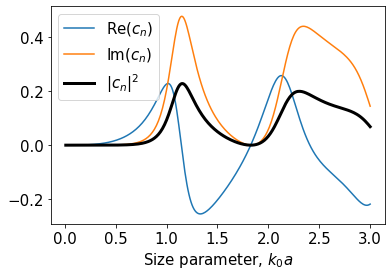

In [25]:
n = 1
eps_host = 1
mu_host = 1

eps_p = 4
mu_p = 1

xx = np.linspace(0.01, stop=3, num=300)

kappa = 1

cn = Mie_chiral_cn(n, eps_host, eps_p, mu_host, mu_p, xx, kappa)

plt.figure()

plt.plot(xx, np.real(cn), label="Re($c_n$)")
plt.plot(xx, np.imag(cn), label="Im($c_n$)")
plt.plot(xx, np.abs(cn)**2, "k", lw=3, label="$|c_n|^2$")


plt.xlabel("Size parameter, $k_0 a$")
plt.legend()
plt.show()